# Decision Trees 

by 
[__Michael Granitzer__ (michael.granitzer@uni-passau.de)]( http://www.mendeley.com/profiles/michael-granitzer/)

with examples taken from the [scikit-learn documentation](http://scikit-learn.org/stable/)

__License__

This work is licensed under a [Creative Commons Attribution 3.0 Unported License](http://creativecommons.org/licenses/by/3.0/)


## Setting up IPython Notebook
The code below simply sets up ipython notebook and displays graphs inline (e.g. as HTML)

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import numpy.linalg as la
np.set_printoptions(precision=3)
def pp_float_list(ps):#pretty print functionality
    return ["%2.3f" % p for p in ps]

## ID3 Implementation

The goal of this exercise is to implement basic ID 3 decision trees. 

Experiments are conducted on the [UCI CAR Dataset](http://archive.ics.uci.edu/ml/machine-learning-databases/car/).

We will cover
  
  * Data Setup
  * Impurity functions and impurity reduction
  * ID3 Algorithm for learning a decistion tree
  * Classifying unseen examples
  * Evaluation using random splitting




## Preparation and Preprocessing



### Download and import the data

In [2]:
#shell scripts for downloading the data and placing it in a corresponding directory
!mkdir CAR 
!curl -o CAR/data "http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
!curl -o CAR/description "http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.names"
#download the description and display it here.
!cat CAR/description

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51867    0 51867    0     0  29218      0 --:--:--  0:00:01 --:--:-- 29270
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3097    0  3097    0     0   9148      0 --:--:-- --:--:-- --:--:--  9244
1. Title: Car Evaluation Database

2. Sources:
   (a) Creator: Marko Bohanec
   (b) Donors: Marko Bohanec   (marko.bohanec@ijs.si)
               Blaz Zupan      (blaz.zupan@ijs.si)
   (c) Date: June, 1997

3. Past Usage:

   The hierarchical decision model, from which this dataset is
   derived, was first presented in 

   M. Bohanec and V. Rajkovic: Knowledge acquisition and explanation for
   multi-attribute decision making. In 8th Intl Workshop on Expert
   Systems and their Applications, Avignon, France. pages 59-78

In [3]:
#load the data via numpy's genfromtxt method
auto = np.genfromtxt("./CAR/data",dtype='object',delimiter=',')
#store the feature names for later use
feature = ['buying','maint','doors','persons','lug_boot','safety','recommendation']
print (auto.shape, len(feature))

(1728, 7) 7


## Implementing impurity functions
In the following, we will implement the impurity reduction function $\Delta\iota(D,\{D_1\ldots D_s\})$ and impurity function(s) $\iota(D,\{D_1\ldots D_s\})$.

$$
\iota(D) = \iota\left(\frac{|\{(x,c(x))\in D : c(x) = c_1\}|}{|D|},...,\frac{|\{(x,c(x))\in D : c(x) = c_k\}|}{|D|}\right)
$$

$$
\Delta\iota(D,\{D_1\ldots D_s\}) = \iota(D) - \sum_{j=1}^{s}\frac{|D_j|}{D}\cdot\iota(D_j)
$$

For theoretical details please refer to the [WEBIS lecture notes, ML:III](http://www.uni-weimar.de/medien/webis/teaching/lecturenotes/machine-learning/unit-en-decision-trees-impurity.pdf))


In [4]:
def impurity_red(X,a,y,impurity,debug=False):
    """
    X: data matrix n rows, d columns
    a: column index of the attribute to evaluate the impurity reduction for
    y: concept vector with n rows and 1 column
    impurity: impurity function of the form impurity(p_1....p_k) with k=|X[a].unique|
    returns: impurity reduction
    Note: for more readable code we do not check any assertion 
    """
    attributes = np.unique(X[:,a])
    concepts = np.unique(y)
    #estimate the probabilty for a concept and the associated impurity h(p)
    p = [np.sum(y==concept)/float(X.shape[0])  for concept in concepts]
    h_p = impurity(np.array(p))
    if debug: print ("\timpurity %0.3f for attribute %d: "%(h_p,a), pp_float_list(p))
    #now do the same for every attribute:
    #i.e. we calculate the probability of all concepts given an attribute (resp. the splitting induced by the attribute)
    h_pa =[]
    d_num=float(X.shape[0])
    for attribute_value in attributes:
        da = X[:,a] == attribute_value
        da_num = float(np.sum(da))
        p = [np.sum(y[da,]==concept)/da_num for concept in concepts]
        h_pa.append((da_num/d_num) * impurity(np.array(p)))
        if debug: print ("\t\t impurity %0.3f for attribute %d with value %s: "%(h_pa[-1],a,attribute_value), pp_float_list(p))
    if debug:  print ("\t Estimated reduction %0.3f"%(h_p-np.sum(h_pa)))
    return h_p-np.sum(h_pa)

And now define the impurity functions.

In [5]:
def gini(p):
    """
    p: numpy array with np.sum(p)=1
    """
    return 1-np.sum(p**2)

def entropy(p):
    """
    p: numpy array with np.sum(p)=1
    """
    idx= np.where(p==0) #consider 0*log(0) as 0
    r=p*np.log2(p)
    r[idx]=0
    return -np.sum(r)
    
def misclass(p):
    """
    p: numpy array with np.sum(p)=1
    """
    return 1-np.max(p)

Lets visualise the functions for the 2D case

/var/folders/6g/gr943dy174xgw3skqb5cdlf00000gn/T/ipykernel_43886/825746565.py:12: RuntimeWarning: divide by zero encountered in log2
  r=p*np.log2(p)
/var/folders/6g/gr943dy174xgw3skqb5cdlf00000gn/T/ipykernel_43886/825746565.py:12: RuntimeWarning: invalid value encountered in multiply
  r=p*np.log2(p)


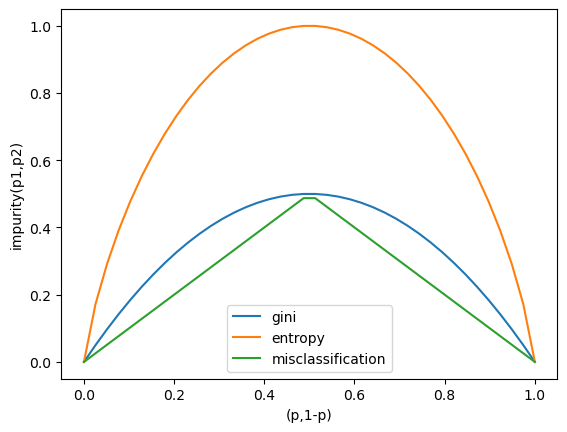

In [6]:
#lets plot the functions for the 2D case 
p1=np.linspace(0,1,40)
imp_gini=[gini(np.array([p,1-p])) for p in p1]
imp_ent=[entropy(np.array([p,1-p])) for p in p1]
imp_mc=[misclass(np.array([p,1-p])) for p in p1]
plt.plot (p1,imp_gini,label="gini")
plt.plot (p1,imp_ent,label="entropy")
plt.plot (p1,imp_mc,label="misclassification")
plt.xlabel("(p,1-p)")
plt.ylabel("impurity(p1,p2)")
plt.legend()
plt.show()

## Splitting

Splitting is done by testing all attributes against the concept attribute and taking the best one. 

We define a function therefore

In [7]:
def get_split_criterion(X,y,impurity,debug=False):
    """
    X: data matrix n rows, d columns
    y: vector with n rows, 1 column containing the target concept
    impurity: impurity function of the form impurity(p_1....p_k) with k=|X[a].unique|
    returns: (idx of best attribute, impurity reduction)
    """
    att_num = X.shape[1]
    imp_reds=[]
    for i in range(att_num):
        imp_reds.append(impurity_red(X,i,y,impurity,debug))
    if debug: print ("Reductions for concept (listed on attributes)",(pp_float_list(imp_reds)))
    best = np.argmax(imp_reds)
    return (best,imp_reds[best])
    

In [8]:
get_split_criterion(auto[:,0:6],auto[:,6],entropy,True)

	impurity 1.206 for attribute 0:  ['0.222', '0.040', '0.700', '0.038']
		 impurity 0.203 for attribute 0 with value b'high':  ['0.250', '0.000', '0.750', '0.000']
		 impurity 0.393 for attribute 0 with value b'low':  ['0.206', '0.106', '0.597', '0.090']
		 impurity 0.351 for attribute 0 with value b'med':  ['0.266', '0.053', '0.620', '0.060']
		 impurity 0.163 for attribute 0 with value b'vhigh':  ['0.167', '0.000', '0.833', '0.000']
	 Estimated reduction 0.096
	impurity 1.206 for attribute 1:  ['0.222', '0.040', '0.700', '0.038']
		 impurity 0.246 for attribute 1 with value b'high':  ['0.243', '0.000', '0.727', '0.030']
		 impurity 0.373 for attribute 1 with value b'low':  ['0.213', '0.106', '0.620', '0.060']
		 impurity 0.351 for attribute 1 with value b'med':  ['0.266', '0.053', '0.620', '0.060']
		 impurity 0.163 for attribute 1 with value b'vhigh':  ['0.167', '0.000', '0.833', '0.000']
	 Estimated reduction 0.074
	impurity 1.206 for attribute 2:  ['0.222', '0.040', '0.700', '0.038

/var/folders/6g/gr943dy174xgw3skqb5cdlf00000gn/T/ipykernel_43886/825746565.py:12: RuntimeWarning: divide by zero encountered in log2
  r=p*np.log2(p)
/var/folders/6g/gr943dy174xgw3skqb5cdlf00000gn/T/ipykernel_43886/825746565.py:12: RuntimeWarning: invalid value encountered in multiply
  r=p*np.log2(p)


(5, 0.26218435655426375)

## The ID 3 Algorithm

Given the impurity reduction and the ID3 Algorithm gets pretty easy now

In [9]:
def id3(X,y,impurity,attributes=None,debug=False,print_progress = True):
    """
    X: data matrix n rows, d columns
    y: vector with n rows and 1 column containing the target concept
    impurity: impurity function of the form impurity(p_1....p_k) with k=|X[a].unique|
    attributes: dictonary containing all attributes relevant for the data and all values per attribut. Will be estimated 
                automatically when it is None
    returns: root note
    """
    def new_node(branches, concept, attribute): #create 
        #new node function for better structure.
        return (branches,concept,attribute)
    
    def max_concept(concepts,uniq):#return the concept frequencies       
        bins = [np.sum(concepts==u) for u in uniq]
        return bins
    
    ########## set label
    uniq_c = np.unique(y) 
    label = uniq_c[np.argmax(max_concept(y,uniq_c))]
    
    ###########  stop criterion 1
    if len(uniq_c)==1: #stop criterion 1: pure class
        if print_progress: 
            print ("\t\t Leaf Node with label %s due to purity"%(label))
        return new_node(None,label,None) #leaf node
    
    ###########  manage attributes (first call and stop criterion)
    if attributes == None: #get feature space: all attributes and their values
       attributes = {key: np.unique(X[:,key]) for key in range(X.shape[1])}
    elif len(attributes) == 0: #stop criterion 2: no attributes
        if print_progress: 
            print ("\t\t Leaf Node with label %s due to exhausted attributes"%(label))
        return new_node(None,label,None)#leaf node
    
    ########## housekeeping    
    level = X.shape[1]-len(attributes)+1 #only for printing purpose   
    
    ###########  get split criterion
    att_index = attributes.keys()
    (a, gain) = get_split_criterion(X[:,0:6], y, impurity, debug)
    if a not in attributes:
        a = [x for x in attributes.keys()][0]
    #a = att_index[a] #split criterion returns the attribute relativ to att_index
    
    ########## housekeeping
    if print_progress: 
        print ("Level %d: choosing attribute %d out of %s with reduction %f"%(level, a, attributes.keys(), gain))
    values = attributes.pop(a)
    
    ########## estimate splits for all values
    splits = [X[:,a]==v for v in values]  
    branches={}
    for v,split in zip(values,splits):
        if not np.any(split):
            if print_progress:
                print ("Level %d: Empty split for value %s of attribute %d"%(level,v,a))
            branches[v] = new_node(None,label,None)
        else: 
            if print_progress: 
                print ("Level %d: Recursion for value %s of attribute %d"%(level,v,a))
            branches[v]=id3(X[split,:],y[split],impurity,attributes=attributes,debug=debug,print_progress=print_progress)
    attributes[a]=values
    return new_node(branches, label, a)
    
    

In [10]:
#test it
root = id3(auto[:,0:6],auto[:,6],entropy,print_progress=True)

Level 1: choosing attribute 5 out of dict_keys([0, 1, 2, 3, 4, 5]) with reduction 0.262184
Level 1: Recursion for value b'high' of attribute 5
Level 2: choosing attribute 3 out of dict_keys([0, 1, 2, 3, 4]) with reduction 0.495905
Level 2: Recursion for value b'2' of attribute 3
		 Leaf Node with label b'unacc' due to purity
Level 2: Recursion for value b'4' of attribute 3
Level 3: choosing attribute 0 out of dict_keys([0, 1, 2, 4]) with reduction 0.490507
Level 3: Recursion for value b'high' of attribute 0
Level 4: choosing attribute 1 out of dict_keys([1, 2, 4]) with reduction 0.811278
Level 4: Recursion for value b'high' of attribute 1
		 Leaf Node with label b'acc' due to purity
Level 4: Recursion for value b'low' of attribute 1
		 Leaf Node with label b'acc' due to purity
Level 4: Recursion for value b'med' of attribute 1
		 Leaf Node with label b'acc' due to purity
Level 4: Recursion for value b'vhigh' of attribute 1
		 Leaf Node with label b'unacc' due to purity
Level 3: Recursi

/var/folders/6g/gr943dy174xgw3skqb5cdlf00000gn/T/ipykernel_43886/825746565.py:12: RuntimeWarning: divide by zero encountered in log2
  r=p*np.log2(p)
/var/folders/6g/gr943dy174xgw3skqb5cdlf00000gn/T/ipykernel_43886/825746565.py:12: RuntimeWarning: invalid value encountered in multiply
  r=p*np.log2(p)


## Classifying the Tree

For classifying we simply need to traverse the tree. However, before that we want to inspect the learned rules and write a general print function

In [11]:
#lets make a function to print the tree

def print_tree(t,attribute_names,test="", level=0):
    """
    t: node of the (sub)tree
    attribute_names: names of the attribute for better printing
    test: string specifying the test that yielded the node t
    level: current level of the tree
    """

    prefix =""
    for i in range(level): 
        prefix += " "
    prefix += " |--(%s):"%(test)
    if t[2]==None:
        print ("%s assign label %s"%(prefix, t[1]))
    else:
        print ("%s test attribute %s "%(prefix,attribute_names[t[2]]))
    
    if t[0] is None: return
    
    for v,branch in t[0].items():
        print_tree(branch,attribute_names,"%s=%s"%(attribute_names[t[2]],v), level+1)
    

In [12]:
print_tree(root,feature)

 |--(): test attribute safety 
  |--(safety=b'high'): test attribute persons 
   |--(persons=b'2'): assign label b'unacc'
   |--(persons=b'4'): test attribute buying 
    |--(buying=b'high'): test attribute maint 
     |--(maint=b'high'): assign label b'acc'
     |--(maint=b'low'): assign label b'acc'
     |--(maint=b'med'): assign label b'acc'
     |--(maint=b'vhigh'): assign label b'unacc'
    |--(buying=b'low'): test attribute maint 
     |--(maint=b'high'): test attribute lug_boot 
      |--(lug_boot=b'big'): assign label b'vgood'
      |--(lug_boot=b'med'): test attribute doors 
       |--(doors=b'2'): assign label b'acc'
       |--(doors=b'3'): assign label b'acc'
       |--(doors=b'4'): assign label b'vgood'
       |--(doors=b'5more'): assign label b'vgood'
      |--(lug_boot=b'small'): assign label b'acc'
     |--(maint=b'low'): test attribute lug_boot 
      |--(lug_boot=b'big'): assign label b'vgood'
      |--(lug_boot=b'med'): test attribute doors 
       |--(doors=b'2'): as

Now we can use the same code, strip away all printing and do the classifcation. 

In [13]:
#Now classify using the tree

def classify_tree(t, x):
    """
    t: node of the tree
    x: row vector containing the examples
    return: concept for x
    """
    
    if t[2]==None:
        return t[1]
    else:
        value = x[t[2]]
        branch = t[0][value]
        if t[0] is None: 
            raise TypeError("Tree not correct. Got None branch for value %s of attribute %s is specified for testing"%(value,t[2]))
        return classify_tree(branch,x)
    
    


Lets test classifying on a single example

In [14]:
print ("According to the attributes %s"%(feature[:-1]))
print ("Should i buy the car %s?"%(auto[52,0:6]))
print ("The car is %s (in truth it is %s)"%(classify_tree(root,auto[52,0:6]),auto[52,6]))

According to the attributes ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']
Should i buy the car [b'vhigh' b'vhigh' b'3' b'more' b'big' b'med']?
The car is b'unacc' (in truth it is b'unacc')


## Evaluating the classification accuracy

Of course we want to estimate the error. Therefore we write a function that given a set of examples predicts their concept. 

In [15]:
def error(X,y,t,debug=False):
    predict =[]
    for i,x in enumerate(X):
        y_pred =classify_tree(t,x)
        if debug:
            print ("%s concept: %s classified as %s"%(y[i]==y_pred,y[i],y_pred))
        predict.append(y_pred)
    correct = y==predict
    return (1-np.sum(correct)/float(len(y)),correct,predict) 

So applying it on the training set we geht the training error (this could be extracted out of the training process also)

In [16]:
(err,cor,pre) = error(auto[:,0:6],auto[:,6],root,False)
print ("Error on training set %f (it is perfect, smells like overfitting)"%(err))

Error on training set 0.000000 (it is perfect, smells like overfitting)


### Random Splitting

However, how good does the decision tree generalize? Lets evaluate it using random splitting.

In [17]:
def random_splitting(X,y,impurity,root,fraction=0.8):
    #prepare test training split
    idx =  np.random.permutation(np.arange(X.shape[0])) # create a array with indices 1..N and permutate it
    bound = int(len(idx)*fraction)
    X_train = X[idx[0:bound],:]  # take the first 80% as training data. 
    y_train = y[idx[0:bound]]  # take the first 80% as training data. 
    X_test  = X[idx[bound:],:]  # take the last 20% as test data. 
    y_test  = y[idx[bound:]]  # take the last 20% as test data. 
    #print len(y_test), len(y_train)
    #now train it
    t = id3(X_train, y_train,impurity,print_progress=False) 
    err_train=error(X_train,y_train,t)[0]
    #and test it
    err_test = error(X_test,y_test,t)[0]
    return (err_train,err_test)


Since we rely on random splitting, there is a chance to get a very bad/very good split. Hence, random splitting has to be conducted several times in a row and the results have to be averaged in order to obtain a reliable estimator. A better way is to do cross-validation.

In [18]:
impurities=[gini,entropy,misclass]
X=auto[:,0:6]
y=auto[:,6]
for imp in impurities:
    etr=0
    ete=0
    splits=20
    for i in range(splits):
        (err_train,err_test)=random_splitting(X,y,imp,root,0.3) #alternative root root[0]['high']
        etr+=err_train
        ete+=err_test
    print ("%s: Average training error %f;Average test error %f"%(imp,etr/splits,ete/splits))
        

<function gini at 0x1606739a0>: Average training error 0.000000;Average test error 0.128347


/var/folders/6g/gr943dy174xgw3skqb5cdlf00000gn/T/ipykernel_43886/825746565.py:12: RuntimeWarning: divide by zero encountered in log2
  r=p*np.log2(p)
/var/folders/6g/gr943dy174xgw3skqb5cdlf00000gn/T/ipykernel_43886/825746565.py:12: RuntimeWarning: invalid value encountered in multiply
  r=p*np.log2(p)


<function entropy at 0x160673a30>: Average training error 0.000000;Average test error 0.125909
<function misclass at 0x160673f40>: Average training error 0.000000;Average test error 0.180909


We can see that generalization error is higher than the training error (depends of course on the number of training samples used)